In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiments/val.csv
/kaggle/input/sentiments/train.csv
/kaggle/input/sentiments/test.csv


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import word_tokenize
# import gensim
# from gensim.models import Word2Vec
from torch import nn, optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, recall_score
import matplotlib.pyplot as plt
import json

In [3]:
train_df = pd.read_csv('/kaggle/input/sentiments/train.csv')
val_df = pd.read_csv('/kaggle/input/sentiments/val.csv')
test_df = pd.read_csv('/kaggle/input/sentiments/test.csv')

# Preprocessing text data
def preprocess_text(text):
    return word_tokenize(text.lower())

train_df['tokens'] = train_df['text'].apply(preprocess_text)
val_df['tokens'] = val_df['text'].apply(preprocess_text)
test_df['tokens'] = test_df['text'].apply(preprocess_text)

# Word2Vec Model Training
sentences = train_df['tokens'].tolist()
model_w2v = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

In [4]:
class SentimentDataset(Dataset):
    def __init__(self, dataframe, model_w2v, max_len=50):
        self.data = dataframe
        self.model_w2v = model_w2v
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['tokens']
        label = self.data.iloc[idx]['label']
        
        vectorized_text = np.zeros((self.max_len, 100))  
        for i, word in enumerate(text[:self.max_len]):
            if word in self.model_w2v.wv:
                vectorized_text[i] = self.model_w2v.wv[word]
        
        return torch.tensor(vectorized_text, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

# Create DataLoader
train_dataset = SentimentDataset(train_df, model_w2v)
val_dataset = SentimentDataset(val_df, model_w2v)
test_dataset = SentimentDataset(test_df, model_w2v)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [2]:
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(GRUModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]  # Get the output of the last time step
        out = self.fc(out)
        return out

In [3]:
from torchinfo import summary
model = GRUModel(100, 256, 2)
print(summary(model, input_size=(8, 50, 100)))

Layer (type:depth-idx)                   Output Shape              Param #
GRUModel                                 [8, 2]                    --
├─GRU: 1-1                               [8, 50, 256]              274,944
├─Linear: 1-2                            [8, 2]                    514
Total params: 275,458
Trainable params: 275,458
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 109.98
Input size (MB): 0.16
Forward/backward pass size (MB): 0.82
Params size (MB): 1.10
Estimated Total Size (MB): 2.08


In [6]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    return running_loss / len(train_loader)

# Evaluation Function with additional metrics
def evaluate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for texts, labels in val_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    
    return val_loss / len(val_loader), accuracy, f1, recall

In [7]:
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, device, epochs=5, patience=3, lr_scheduler=None):
    best_val_acc = 0.0
    best_f1 = 0.0
    patience_counter = 0
    best_model = None
    train_losses = []
    val_accuracies = []
    val_f1_scores = []

    for epoch in range(epochs):
        train_loss = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_accuracy, val_f1, val_recall = evaluate(model, val_loader, criterion, device)
        
        if lr_scheduler:
            lr_scheduler.step(val_loss)
        
        train_losses.append(train_loss)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)
        
        print(f"Epoch [{epoch+1}/{epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.4f}, "
              f"Val F1: {val_f1:.4f}, "
              f"Val Recall: {val_recall:.4f}")
        
        # Update model if validation accuracy is better
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_f1 = val_f1
            best_model = model.state_dict()
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print("Training stopped due to patience limit.")
            break
    
    model.load_state_dict(best_model)
    
    # Plot loss and performance
    plt.figure(figsize=(12, 6))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_accuracies, label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Train Loss vs Validation Accuracy")
    plt.legend()
    
    # F1 Score plot
    plt.subplot(1, 2, 2)
    plt.plot(val_f1_scores, label="Val F1 Score", color='green')
    plt.xlabel("Epochs")
    plt.ylabel("F1 Score")
    plt.title("Validation F1 Score")
    plt.legend()
    
    plt.show()

    return model

In [8]:
def test(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    
    return accuracy, f1, recall

In [9]:
def random_search(train_loader, val_loader, device, epochs=5):
    # Define hyperparameter space
    hidden_dims = [64, 128, 256]
    learning_rates = [0.0001, 0.001, 0.01]
    batch_sizes = [8, 16, 32]
    
    best_accuracy = 0.0
    best_f1 = 0.0
    best_recall = 0.0
    best_model = None
    best_params = None
    
    # Random search over hyperparameters
    for hidden_dim in hidden_dims:
        for lr in learning_rates:
            for batch_size in batch_sizes:
                print(f"Training with hidden_dim={hidden_dim}, lr={lr}, batch_size={batch_size}")
                
                # Recreate datasets and dataloaders with current batch_size
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
                
                # Initialize model, optimizer, and loss function
                model = GRUModel(input_dim=100, hidden_dim=hidden_dim, output_dim=2).to(device)
                optimizer = optim.Adam(model.parameters(), lr=lr)
                criterion = nn.CrossEntropyLoss()
                
                # Train and evaluate model
                trained_model = train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, device, epochs=epochs)
                
                # Evaluate model on validation set
                val_accuracy, val_f1, val_recall = test(trained_model, val_loader, device)
                
                # Store best model and parameters
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_f1 = val_f1
                    best_recall = val_recall
                    best_model = trained_model
                    best_params = (hidden_dim, lr, batch_size)
                
                print(f"Validation Accuracy: {val_accuracy:.4f}, F1: {val_f1:.4f}, Recall: {val_recall:.4f}")
    
    print(f"\nBest Hyperparameters: Hidden Dim: {best_params[0]}, LR: {best_params[1]}, Batch Size: {best_params[2]}")
    print(f"Best Validation Accuracy: {best_accuracy:.4f}, F1: {best_f1:.4f}, Recall: {best_recall:.4f}")
    
    return best_model, best_params


Training with hidden_dim=64, lr=0.0001, batch_size=8
Epoch [1/10], Train Loss: 0.4307, Val Loss: 0.3655, Val Accuracy: 0.8504, Val F1: 0.8318, Val Recall: 0.8504
Epoch [2/10], Train Loss: 0.3448, Val Loss: 0.3345, Val Accuracy: 0.8625, Val F1: 0.8462, Val Recall: 0.8625
Epoch [3/10], Train Loss: 0.3239, Val Loss: 0.3385, Val Accuracy: 0.8721, Val F1: 0.8542, Val Recall: 0.8721
Epoch [4/10], Train Loss: 0.3116, Val Loss: 0.3234, Val Accuracy: 0.8692, Val F1: 0.8588, Val Recall: 0.8692
Epoch [5/10], Train Loss: 0.3029, Val Loss: 0.3115, Val Accuracy: 0.8731, Val F1: 0.8574, Val Recall: 0.8731
Epoch [6/10], Train Loss: 0.2952, Val Loss: 0.3104, Val Accuracy: 0.8762, Val F1: 0.8607, Val Recall: 0.8762
Epoch [7/10], Train Loss: 0.2881, Val Loss: 0.3064, Val Accuracy: 0.8762, Val F1: 0.8672, Val Recall: 0.8762
Epoch [8/10], Train Loss: 0.2826, Val Loss: 0.3162, Val Accuracy: 0.8692, Val F1: 0.8659, Val Recall: 0.8692
Epoch [9/10], Train Loss: 0.2766, Val Loss: 0.3402, Val Accuracy: 0.8749, V

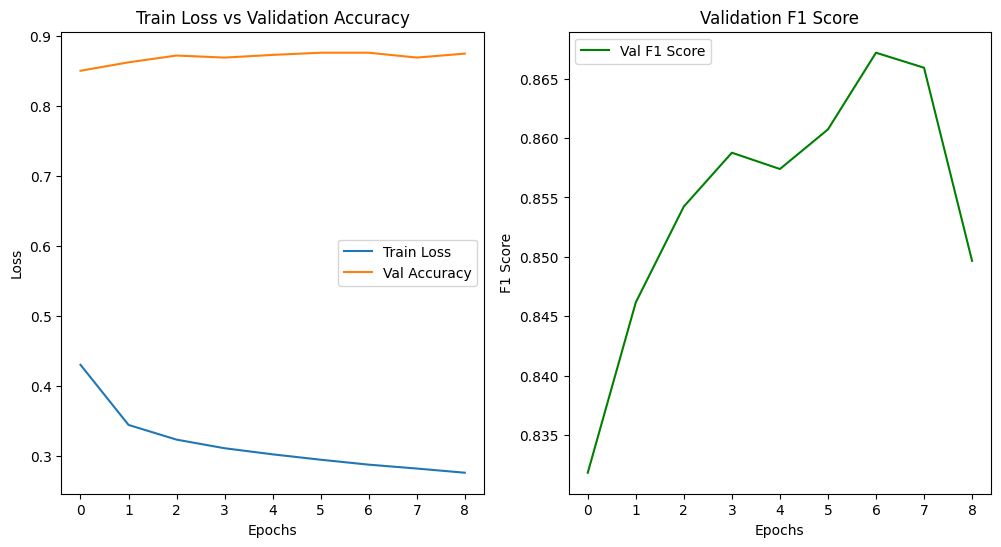

Validation Accuracy: 0.8749, F1: 0.8497, Recall: 0.8749
Training with hidden_dim=64, lr=0.0001, batch_size=16
Epoch [1/10], Train Loss: 0.4285, Val Loss: 0.3550, Val Accuracy: 0.8564, Val F1: 0.8407, Val Recall: 0.8564
Epoch [2/10], Train Loss: 0.3446, Val Loss: 0.3473, Val Accuracy: 0.8564, Val F1: 0.8498, Val Recall: 0.8564
Epoch [3/10], Train Loss: 0.3258, Val Loss: 0.3299, Val Accuracy: 0.8681, Val F1: 0.8542, Val Recall: 0.8681
Epoch [4/10], Train Loss: 0.3150, Val Loss: 0.3223, Val Accuracy: 0.8714, Val F1: 0.8574, Val Recall: 0.8714
Epoch [5/10], Train Loss: 0.3069, Val Loss: 0.3169, Val Accuracy: 0.8756, Val F1: 0.8629, Val Recall: 0.8756
Epoch [6/10], Train Loss: 0.3000, Val Loss: 0.3175, Val Accuracy: 0.8745, Val F1: 0.8567, Val Recall: 0.8745
Epoch [7/10], Train Loss: 0.2942, Val Loss: 0.3144, Val Accuracy: 0.8760, Val F1: 0.8647, Val Recall: 0.8760
Epoch [8/10], Train Loss: 0.2894, Val Loss: 0.3101, Val Accuracy: 0.8785, Val F1: 0.8680, Val Recall: 0.8785
Epoch [9/10], Trai

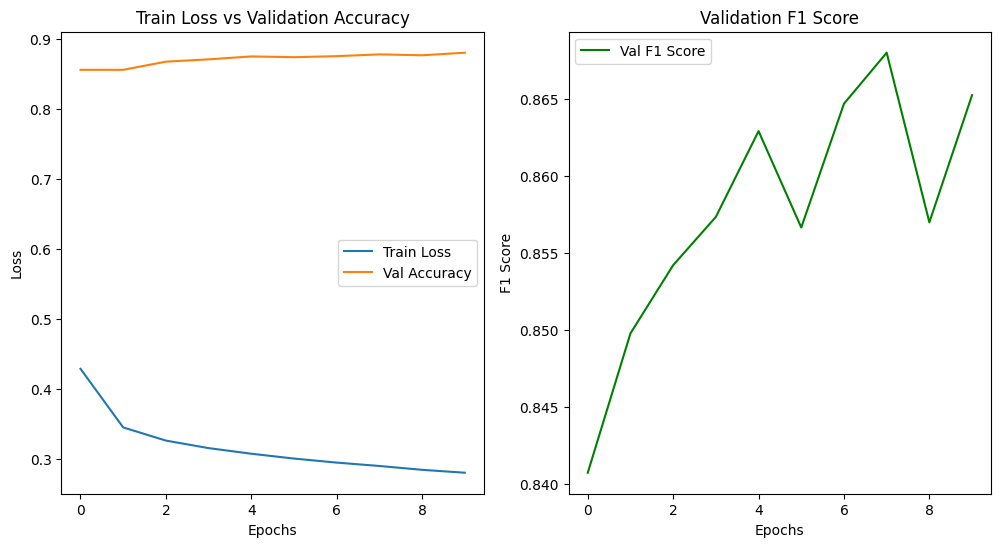

Validation Accuracy: 0.8809, F1: 0.8653, Recall: 0.8809
Training with hidden_dim=64, lr=0.0001, batch_size=32
Epoch [1/10], Train Loss: 0.4717, Val Loss: 0.3692, Val Accuracy: 0.8447, Val F1: 0.7986, Val Recall: 0.8447
Epoch [2/10], Train Loss: 0.3645, Val Loss: 0.3477, Val Accuracy: 0.8532, Val F1: 0.8409, Val Recall: 0.8532
Epoch [3/10], Train Loss: 0.3394, Val Loss: 0.3372, Val Accuracy: 0.8630, Val F1: 0.8386, Val Recall: 0.8630
Epoch [4/10], Train Loss: 0.3270, Val Loss: 0.3384, Val Accuracy: 0.8676, Val F1: 0.8437, Val Recall: 0.8676
Epoch [5/10], Train Loss: 0.3181, Val Loss: 0.3228, Val Accuracy: 0.8683, Val F1: 0.8493, Val Recall: 0.8683
Epoch [6/10], Train Loss: 0.3115, Val Loss: 0.3184, Val Accuracy: 0.8705, Val F1: 0.8515, Val Recall: 0.8705
Epoch [7/10], Train Loss: 0.3060, Val Loss: 0.3160, Val Accuracy: 0.8727, Val F1: 0.8589, Val Recall: 0.8727
Epoch [8/10], Train Loss: 0.3011, Val Loss: 0.3146, Val Accuracy: 0.8756, Val F1: 0.8616, Val Recall: 0.8756
Epoch [9/10], Trai

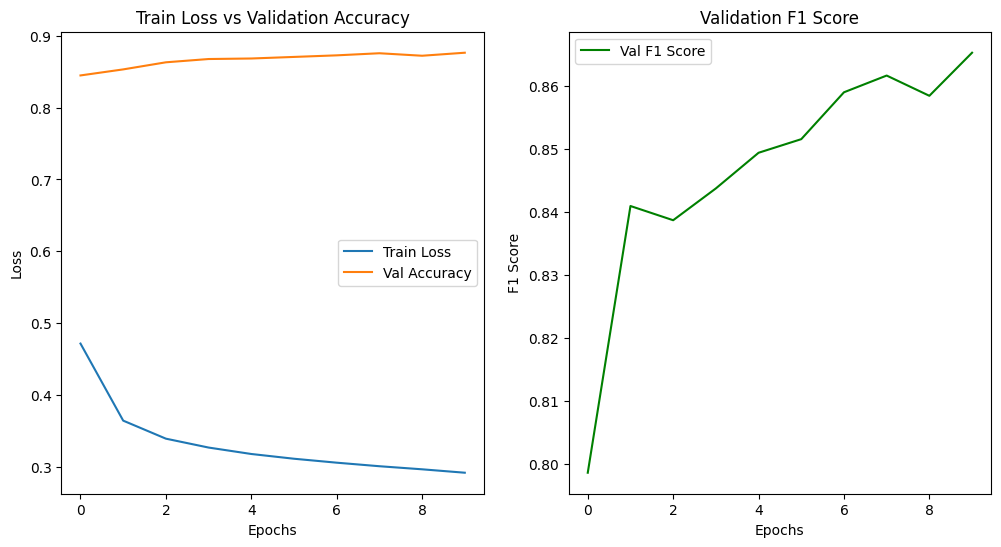

Validation Accuracy: 0.8763, F1: 0.8652, Recall: 0.8763
Training with hidden_dim=64, lr=0.001, batch_size=8
Epoch [1/10], Train Loss: 0.3601, Val Loss: 0.3193, Val Accuracy: 0.8701, Val F1: 0.8528, Val Recall: 0.8701
Epoch [2/10], Train Loss: 0.2986, Val Loss: 0.3071, Val Accuracy: 0.8815, Val F1: 0.8647, Val Recall: 0.8815
Epoch [3/10], Train Loss: 0.2755, Val Loss: 0.3113, Val Accuracy: 0.8795, Val F1: 0.8603, Val Recall: 0.8795
Epoch [4/10], Train Loss: 0.2528, Val Loss: 0.3109, Val Accuracy: 0.8820, Val F1: 0.8617, Val Recall: 0.8820
Epoch [5/10], Train Loss: 0.2314, Val Loss: 0.3178, Val Accuracy: 0.8809, Val F1: 0.8673, Val Recall: 0.8809
Epoch [6/10], Train Loss: 0.2128, Val Loss: 0.3186, Val Accuracy: 0.8811, Val F1: 0.8736, Val Recall: 0.8811
Epoch [7/10], Train Loss: 0.1924, Val Loss: 0.3374, Val Accuracy: 0.8758, Val F1: 0.8670, Val Recall: 0.8758
Training stopped due to patience limit.


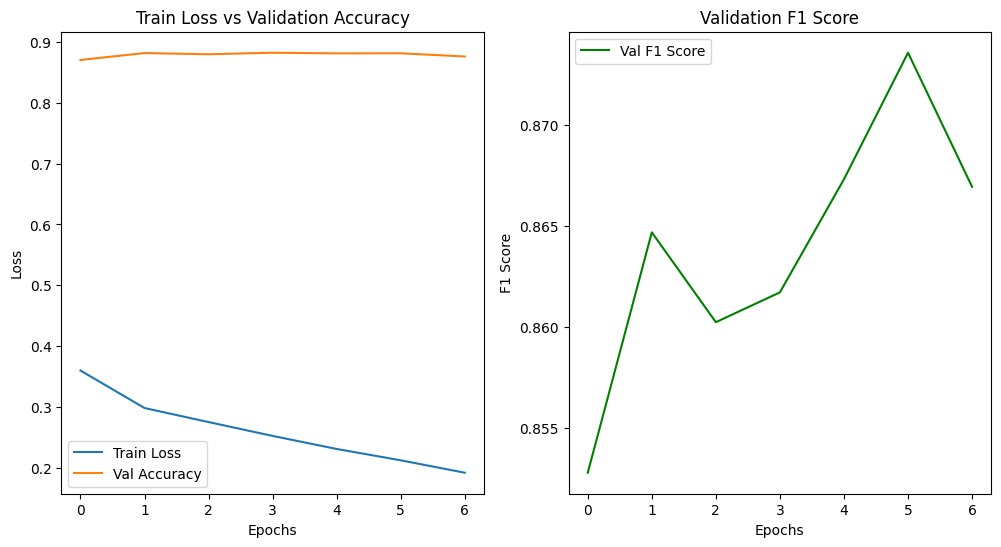

Validation Accuracy: 0.8758, F1: 0.8670, Recall: 0.8758
Training with hidden_dim=64, lr=0.001, batch_size=16
Epoch [1/10], Train Loss: 0.3896, Val Loss: 0.3311, Val Accuracy: 0.8689, Val F1: 0.8560, Val Recall: 0.8689
Epoch [2/10], Train Loss: 0.3165, Val Loss: 0.3124, Val Accuracy: 0.8745, Val F1: 0.8616, Val Recall: 0.8745
Epoch [3/10], Train Loss: 0.2902, Val Loss: 0.3208, Val Accuracy: 0.8795, Val F1: 0.8630, Val Recall: 0.8795
Epoch [4/10], Train Loss: 0.2699, Val Loss: 0.3007, Val Accuracy: 0.8800, Val F1: 0.8661, Val Recall: 0.8800
Epoch [5/10], Train Loss: 0.2500, Val Loss: 0.2997, Val Accuracy: 0.8833, Val F1: 0.8732, Val Recall: 0.8833
Epoch [6/10], Train Loss: 0.2305, Val Loss: 0.3175, Val Accuracy: 0.8800, Val F1: 0.8675, Val Recall: 0.8800
Epoch [7/10], Train Loss: 0.2104, Val Loss: 0.3293, Val Accuracy: 0.8743, Val F1: 0.8675, Val Recall: 0.8743
Epoch [8/10], Train Loss: 0.1917, Val Loss: 0.3326, Val Accuracy: 0.8753, Val F1: 0.8638, Val Recall: 0.8753
Training stopped du

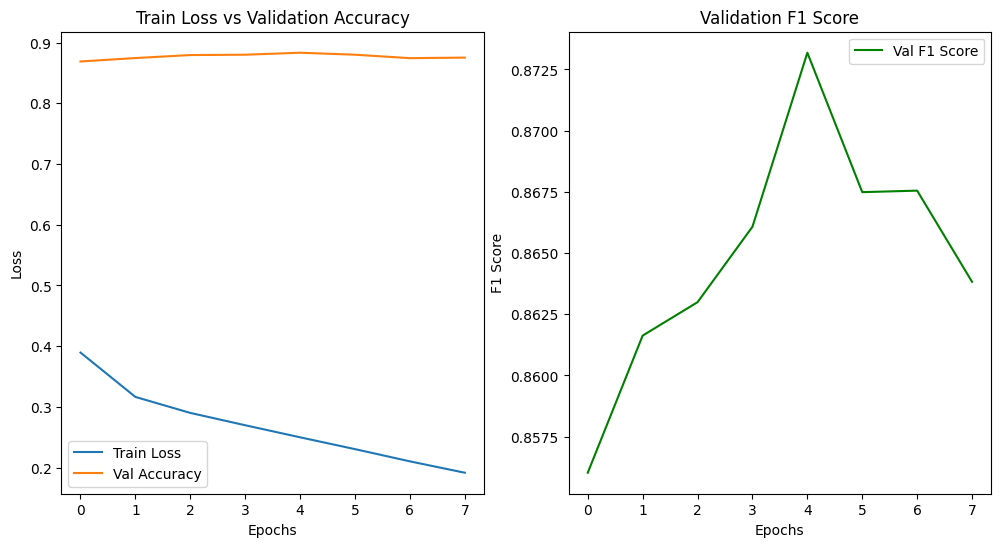

Validation Accuracy: 0.8753, F1: 0.8638, Recall: 0.8753
Training with hidden_dim=64, lr=0.001, batch_size=32
Epoch [1/10], Train Loss: 0.3760, Val Loss: 0.3332, Val Accuracy: 0.8681, Val F1: 0.8386, Val Recall: 0.8681
Epoch [2/10], Train Loss: 0.3091, Val Loss: 0.3119, Val Accuracy: 0.8754, Val F1: 0.8600, Val Recall: 0.8754
Epoch [3/10], Train Loss: 0.2860, Val Loss: 0.3044, Val Accuracy: 0.8813, Val F1: 0.8695, Val Recall: 0.8813
Epoch [4/10], Train Loss: 0.2678, Val Loss: 0.2987, Val Accuracy: 0.8793, Val F1: 0.8613, Val Recall: 0.8793
Epoch [5/10], Train Loss: 0.2493, Val Loss: 0.3121, Val Accuracy: 0.8813, Val F1: 0.8682, Val Recall: 0.8813
Epoch [6/10], Train Loss: 0.2310, Val Loss: 0.3328, Val Accuracy: 0.8796, Val F1: 0.8702, Val Recall: 0.8796
Training stopped due to patience limit.


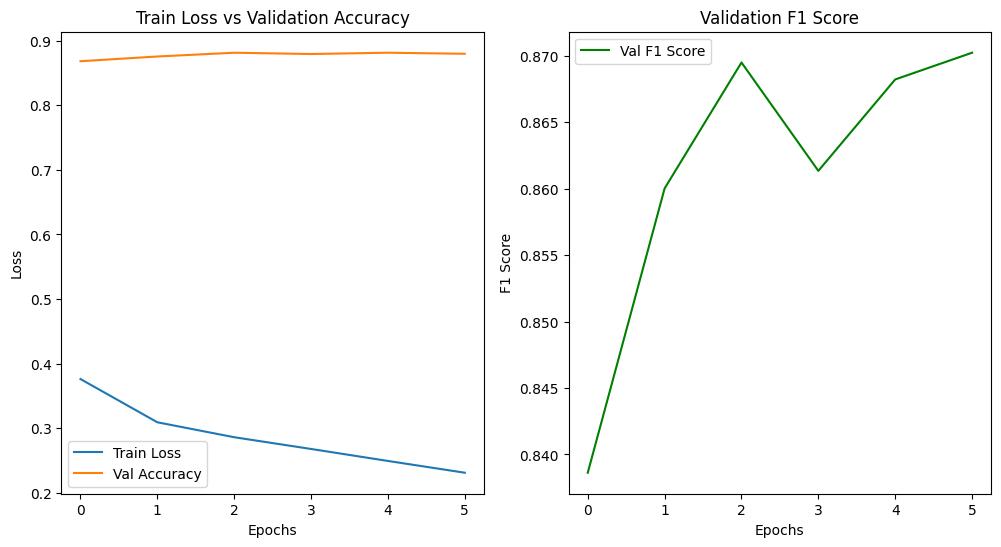

Validation Accuracy: 0.8796, F1: 0.8702, Recall: 0.8796
Training with hidden_dim=64, lr=0.01, batch_size=8
Epoch [1/10], Train Loss: 0.4008, Val Loss: 0.3907, Val Accuracy: 0.8449, Val F1: 0.8188, Val Recall: 0.8449
Epoch [2/10], Train Loss: 0.4097, Val Loss: 0.4065, Val Accuracy: 0.8318, Val F1: 0.8083, Val Recall: 0.8318
Epoch [3/10], Train Loss: 0.4324, Val Loss: 0.4367, Val Accuracy: 0.8365, Val F1: 0.7728, Val Recall: 0.8365
Epoch [4/10], Train Loss: 0.4667, Val Loss: 0.4778, Val Accuracy: 0.8004, Val F1: 0.7767, Val Recall: 0.8004
Training stopped due to patience limit.


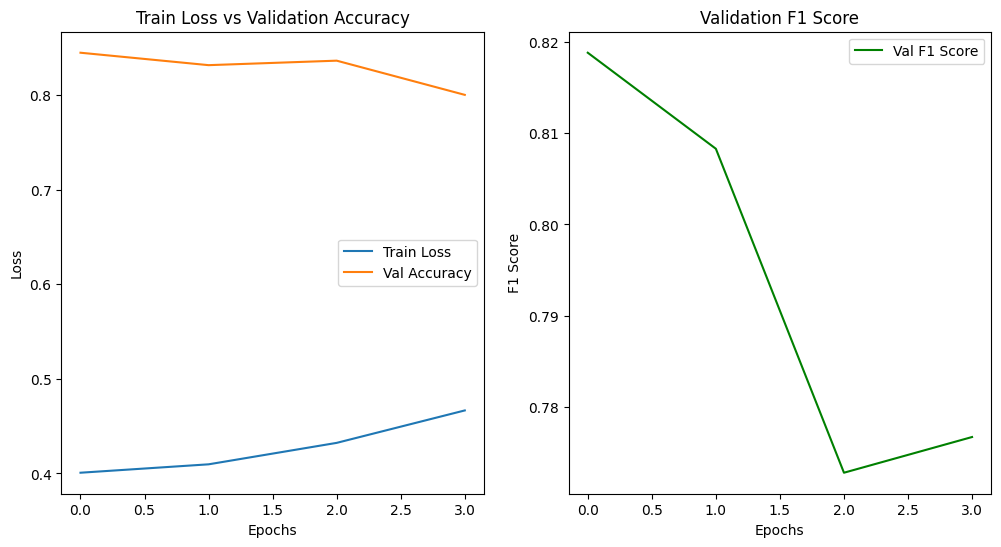

Validation Accuracy: 0.8004, F1: 0.7767, Recall: 0.8004
Training with hidden_dim=64, lr=0.01, batch_size=16
Epoch [1/10], Train Loss: 0.3754, Val Loss: 0.3553, Val Accuracy: 0.8634, Val F1: 0.8418, Val Recall: 0.8634
Epoch [2/10], Train Loss: 0.3534, Val Loss: 0.3570, Val Accuracy: 0.8617, Val F1: 0.8376, Val Recall: 0.8617
Epoch [3/10], Train Loss: 0.3559, Val Loss: 0.4070, Val Accuracy: 0.8628, Val F1: 0.8294, Val Recall: 0.8628
Epoch [4/10], Train Loss: 0.3662, Val Loss: 0.3588, Val Accuracy: 0.8564, Val F1: 0.8450, Val Recall: 0.8564
Training stopped due to patience limit.


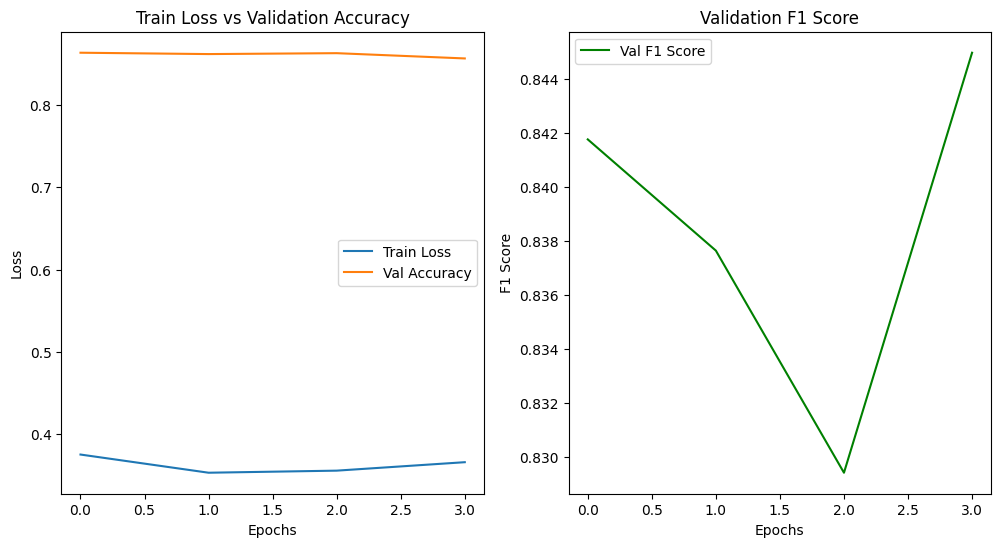

Validation Accuracy: 0.8564, F1: 0.8450, Recall: 0.8564
Training with hidden_dim=64, lr=0.01, batch_size=32
Epoch [1/10], Train Loss: 0.3581, Val Loss: 0.3431, Val Accuracy: 0.8668, Val F1: 0.8430, Val Recall: 0.8668
Epoch [2/10], Train Loss: 0.3319, Val Loss: 0.3287, Val Accuracy: 0.8718, Val F1: 0.8556, Val Recall: 0.8718
Epoch [3/10], Train Loss: 0.3255, Val Loss: 0.3416, Val Accuracy: 0.8630, Val F1: 0.8507, Val Recall: 0.8630
Epoch [4/10], Train Loss: 0.3266, Val Loss: 0.3388, Val Accuracy: 0.8721, Val F1: 0.8546, Val Recall: 0.8721
Epoch [5/10], Train Loss: 0.3467, Val Loss: 0.3693, Val Accuracy: 0.8599, Val F1: 0.8283, Val Recall: 0.8599
Epoch [6/10], Train Loss: 0.3547, Val Loss: 0.3616, Val Accuracy: 0.8665, Val F1: 0.8396, Val Recall: 0.8665
Epoch [7/10], Train Loss: 0.3499, Val Loss: 0.3600, Val Accuracy: 0.8636, Val F1: 0.8446, Val Recall: 0.8636
Training stopped due to patience limit.


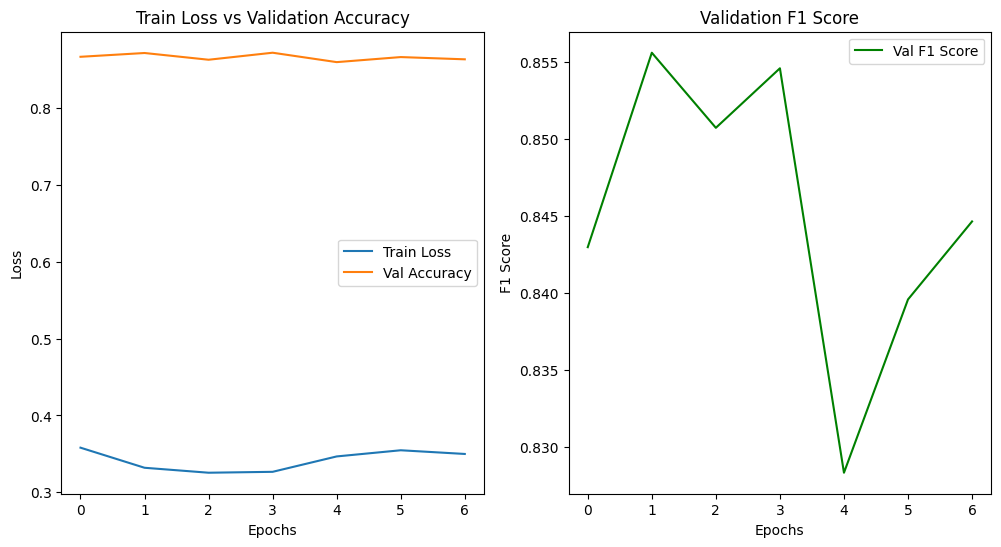

Validation Accuracy: 0.8636, F1: 0.8446, Recall: 0.8636
Training with hidden_dim=128, lr=0.0001, batch_size=8
Epoch [1/10], Train Loss: 0.3962, Val Loss: 0.3455, Val Accuracy: 0.8586, Val F1: 0.8370, Val Recall: 0.8586
Epoch [2/10], Train Loss: 0.3355, Val Loss: 0.3291, Val Accuracy: 0.8679, Val F1: 0.8511, Val Recall: 0.8679
Epoch [3/10], Train Loss: 0.3197, Val Loss: 0.3266, Val Accuracy: 0.8716, Val F1: 0.8471, Val Recall: 0.8716
Epoch [4/10], Train Loss: 0.3071, Val Loss: 0.3269, Val Accuracy: 0.8714, Val F1: 0.8461, Val Recall: 0.8714
Epoch [5/10], Train Loss: 0.2978, Val Loss: 0.3133, Val Accuracy: 0.8771, Val F1: 0.8569, Val Recall: 0.8771
Epoch [6/10], Train Loss: 0.2889, Val Loss: 0.3056, Val Accuracy: 0.8793, Val F1: 0.8630, Val Recall: 0.8793
Epoch [7/10], Train Loss: 0.2804, Val Loss: 0.3083, Val Accuracy: 0.8811, Val F1: 0.8711, Val Recall: 0.8811
Epoch [8/10], Train Loss: 0.2713, Val Loss: 0.3092, Val Accuracy: 0.8784, Val F1: 0.8604, Val Recall: 0.8784
Epoch [9/10], Trai

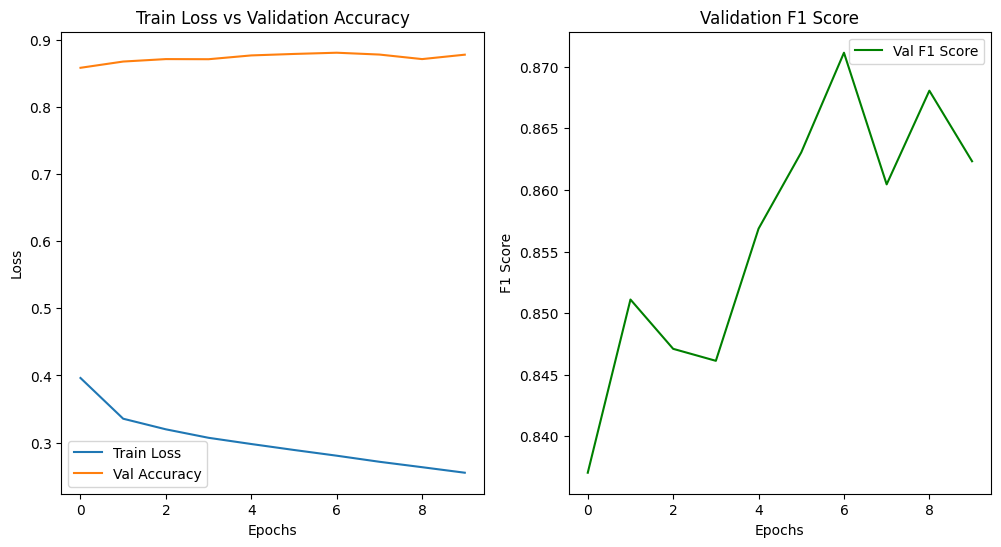

Validation Accuracy: 0.8782, F1: 0.8623, Recall: 0.8782
Training with hidden_dim=128, lr=0.0001, batch_size=16
Epoch [1/10], Train Loss: 0.4083, Val Loss: 0.3451, Val Accuracy: 0.8552, Val F1: 0.8376, Val Recall: 0.8552
Epoch [2/10], Train Loss: 0.3408, Val Loss: 0.3616, Val Accuracy: 0.8636, Val F1: 0.8339, Val Recall: 0.8636
Epoch [3/10], Train Loss: 0.3252, Val Loss: 0.3284, Val Accuracy: 0.8690, Val F1: 0.8493, Val Recall: 0.8690
Epoch [4/10], Train Loss: 0.3142, Val Loss: 0.3277, Val Accuracy: 0.8725, Val F1: 0.8491, Val Recall: 0.8725
Epoch [5/10], Train Loss: 0.3062, Val Loss: 0.3337, Val Accuracy: 0.8732, Val F1: 0.8515, Val Recall: 0.8732
Epoch [6/10], Train Loss: 0.2993, Val Loss: 0.3407, Val Accuracy: 0.8732, Val F1: 0.8475, Val Recall: 0.8732
Epoch [7/10], Train Loss: 0.2925, Val Loss: 0.3085, Val Accuracy: 0.8796, Val F1: 0.8655, Val Recall: 0.8796
Epoch [8/10], Train Loss: 0.2867, Val Loss: 0.3174, Val Accuracy: 0.8784, Val F1: 0.8603, Val Recall: 0.8784
Epoch [9/10], Tra

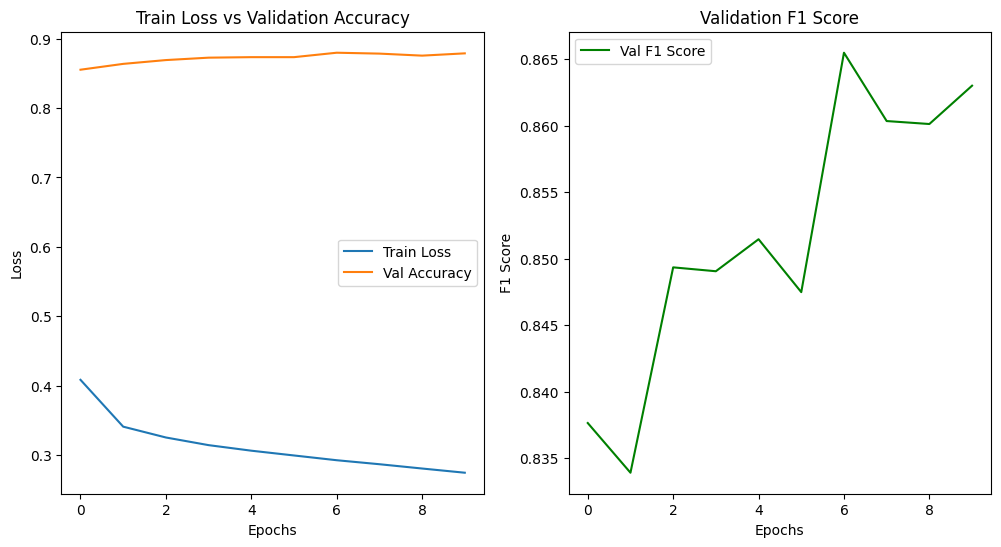

Validation Accuracy: 0.8787, F1: 0.8630, Recall: 0.8787
Training with hidden_dim=128, lr=0.0001, batch_size=32
Epoch [1/10], Train Loss: 0.4279, Val Loss: 0.3642, Val Accuracy: 0.8546, Val F1: 0.8320, Val Recall: 0.8546
Epoch [2/10], Train Loss: 0.3454, Val Loss: 0.3326, Val Accuracy: 0.8637, Val F1: 0.8432, Val Recall: 0.8637
Epoch [3/10], Train Loss: 0.3284, Val Loss: 0.3265, Val Accuracy: 0.8678, Val F1: 0.8432, Val Recall: 0.8678
Epoch [4/10], Train Loss: 0.3173, Val Loss: 0.3301, Val Accuracy: 0.8714, Val F1: 0.8488, Val Recall: 0.8714
Epoch [5/10], Train Loss: 0.3096, Val Loss: 0.3153, Val Accuracy: 0.8751, Val F1: 0.8600, Val Recall: 0.8751
Epoch [6/10], Train Loss: 0.3028, Val Loss: 0.3121, Val Accuracy: 0.8753, Val F1: 0.8561, Val Recall: 0.8753
Epoch [7/10], Train Loss: 0.2974, Val Loss: 0.3124, Val Accuracy: 0.8762, Val F1: 0.8632, Val Recall: 0.8762
Epoch [8/10], Train Loss: 0.2928, Val Loss: 0.3120, Val Accuracy: 0.8787, Val F1: 0.8682, Val Recall: 0.8787
Epoch [9/10], Tra

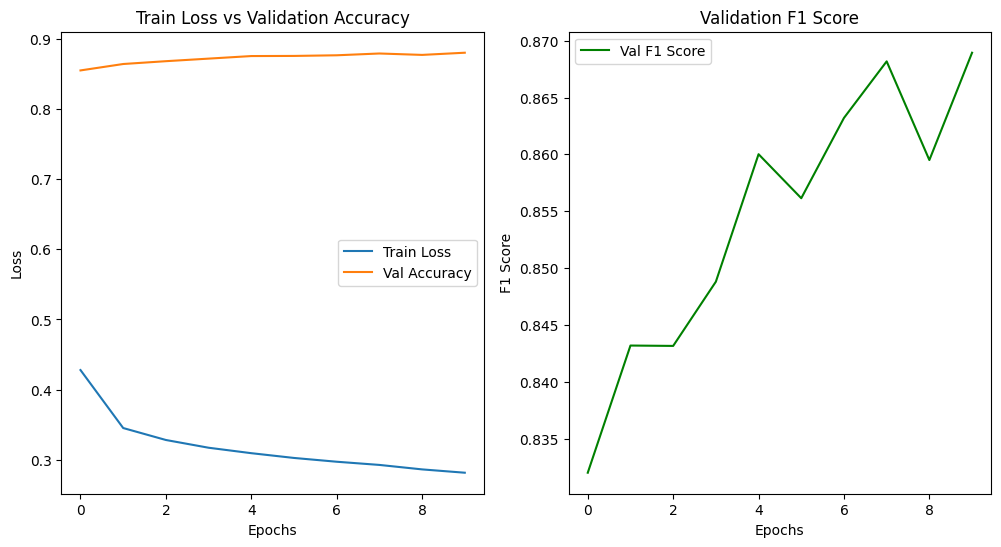

Validation Accuracy: 0.8798, F1: 0.8689, Recall: 0.8798
Training with hidden_dim=128, lr=0.001, batch_size=8
Epoch [1/10], Train Loss: 0.3655, Val Loss: 0.3474, Val Accuracy: 0.8729, Val F1: 0.8461, Val Recall: 0.8729
Epoch [2/10], Train Loss: 0.2984, Val Loss: 0.3147, Val Accuracy: 0.8798, Val F1: 0.8572, Val Recall: 0.8798
Epoch [3/10], Train Loss: 0.2661, Val Loss: 0.2968, Val Accuracy: 0.8846, Val F1: 0.8702, Val Recall: 0.8846
Epoch [4/10], Train Loss: 0.2326, Val Loss: 0.3069, Val Accuracy: 0.8789, Val F1: 0.8715, Val Recall: 0.8789
Epoch [5/10], Train Loss: 0.1973, Val Loss: 0.3225, Val Accuracy: 0.8791, Val F1: 0.8716, Val Recall: 0.8791
Epoch [6/10], Train Loss: 0.1638, Val Loss: 0.3696, Val Accuracy: 0.8732, Val F1: 0.8672, Val Recall: 0.8732
Training stopped due to patience limit.


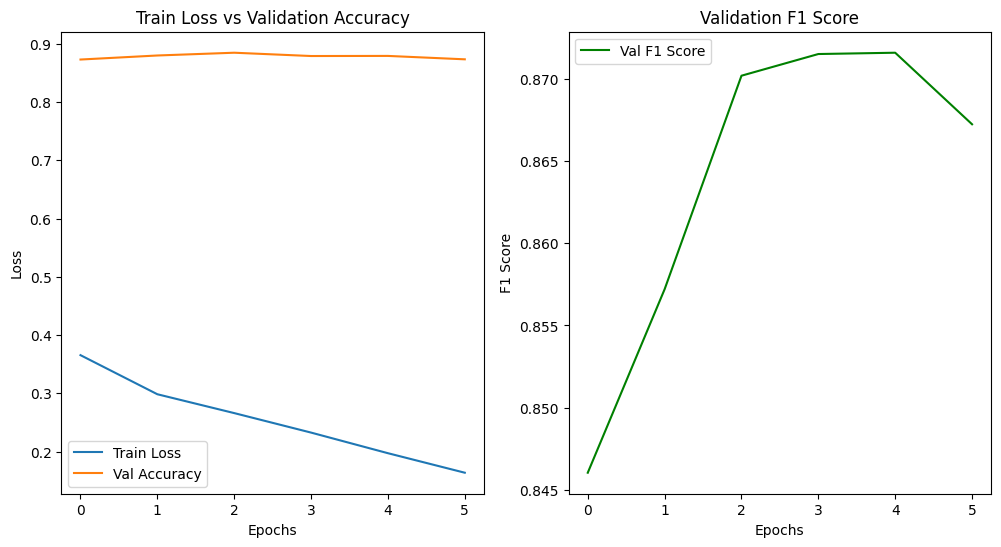

Validation Accuracy: 0.8732, F1: 0.8672, Recall: 0.8732
Training with hidden_dim=128, lr=0.001, batch_size=16
Epoch [1/10], Train Loss: 0.3672, Val Loss: 0.3314, Val Accuracy: 0.8731, Val F1: 0.8468, Val Recall: 0.8731
Epoch [2/10], Train Loss: 0.3005, Val Loss: 0.3021, Val Accuracy: 0.8791, Val F1: 0.8631, Val Recall: 0.8791
Epoch [3/10], Train Loss: 0.2687, Val Loss: 0.2919, Val Accuracy: 0.8844, Val F1: 0.8729, Val Recall: 0.8844
Epoch [4/10], Train Loss: 0.2344, Val Loss: 0.3069, Val Accuracy: 0.8807, Val F1: 0.8717, Val Recall: 0.8807
Epoch [5/10], Train Loss: 0.1973, Val Loss: 0.3204, Val Accuracy: 0.8800, Val F1: 0.8721, Val Recall: 0.8800
Epoch [6/10], Train Loss: 0.1574, Val Loss: 0.3553, Val Accuracy: 0.8805, Val F1: 0.8733, Val Recall: 0.8805
Training stopped due to patience limit.


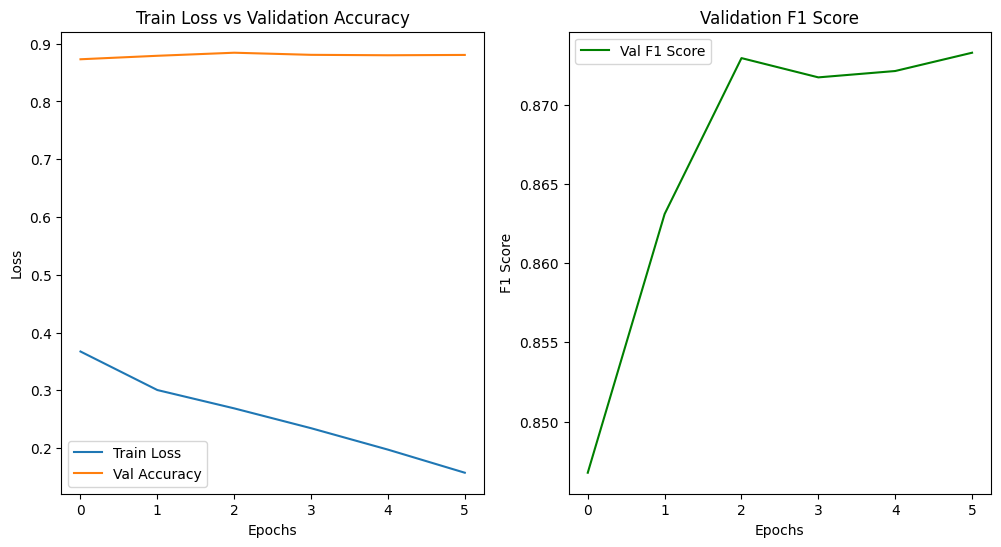

Validation Accuracy: 0.8805, F1: 0.8733, Recall: 0.8805
Training with hidden_dim=128, lr=0.001, batch_size=32
Epoch [1/10], Train Loss: 0.3748, Val Loss: 0.3280, Val Accuracy: 0.8745, Val F1: 0.8558, Val Recall: 0.8745
Epoch [2/10], Train Loss: 0.3042, Val Loss: 0.3037, Val Accuracy: 0.8815, Val F1: 0.8634, Val Recall: 0.8815
Epoch [3/10], Train Loss: 0.2775, Val Loss: 0.3028, Val Accuracy: 0.8809, Val F1: 0.8669, Val Recall: 0.8809
Epoch [4/10], Train Loss: 0.2498, Val Loss: 0.3062, Val Accuracy: 0.8820, Val F1: 0.8714, Val Recall: 0.8820
Epoch [5/10], Train Loss: 0.2215, Val Loss: 0.3081, Val Accuracy: 0.8831, Val F1: 0.8720, Val Recall: 0.8831
Epoch [6/10], Train Loss: 0.1860, Val Loss: 0.3477, Val Accuracy: 0.8749, Val F1: 0.8682, Val Recall: 0.8749
Epoch [7/10], Train Loss: 0.1545, Val Loss: 0.3572, Val Accuracy: 0.8762, Val F1: 0.8703, Val Recall: 0.8762
Epoch [8/10], Train Loss: 0.1237, Val Loss: 0.3953, Val Accuracy: 0.8816, Val F1: 0.8708, Val Recall: 0.8816
Training stopped d

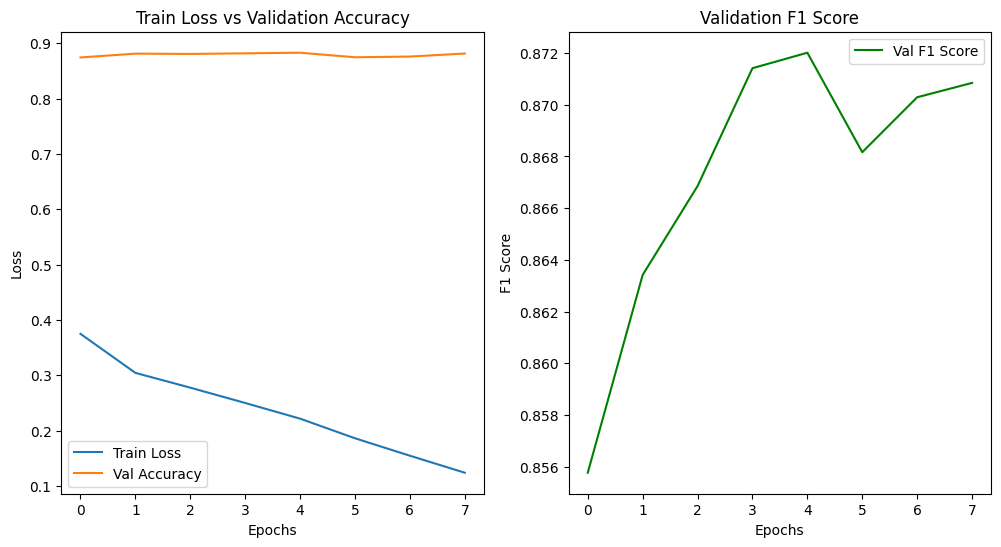

Validation Accuracy: 0.8816, F1: 0.8708, Recall: 0.8816
Training with hidden_dim=128, lr=0.01, batch_size=8
Epoch [1/10], Train Loss: 0.4822, Val Loss: 0.4778, Val Accuracy: 0.8035, Val F1: 0.7720, Val Recall: 0.8035
Epoch [2/10], Train Loss: 0.5070, Val Loss: 0.5131, Val Accuracy: 0.7618, Val F1: 0.7650, Val Recall: 0.7618
Epoch [3/10], Train Loss: 0.5019, Val Loss: 0.4964, Val Accuracy: 0.8283, Val F1: 0.7640, Val Recall: 0.8283
Epoch [4/10], Train Loss: 0.5348, Val Loss: 0.4659, Val Accuracy: 0.8267, Val F1: 0.7664, Val Recall: 0.8267
Epoch [5/10], Train Loss: 0.5312, Val Loss: 0.4798, Val Accuracy: 0.8332, Val F1: 0.7641, Val Recall: 0.8332
Epoch [6/10], Train Loss: 0.5272, Val Loss: 0.5337, Val Accuracy: 0.7492, Val F1: 0.7531, Val Recall: 0.7492
Epoch [7/10], Train Loss: 0.5275, Val Loss: 0.4709, Val Accuracy: 0.8168, Val F1: 0.7717, Val Recall: 0.8168
Epoch [8/10], Train Loss: 0.5232, Val Loss: 0.4583, Val Accuracy: 0.8164, Val F1: 0.7682, Val Recall: 0.8164
Training stopped due

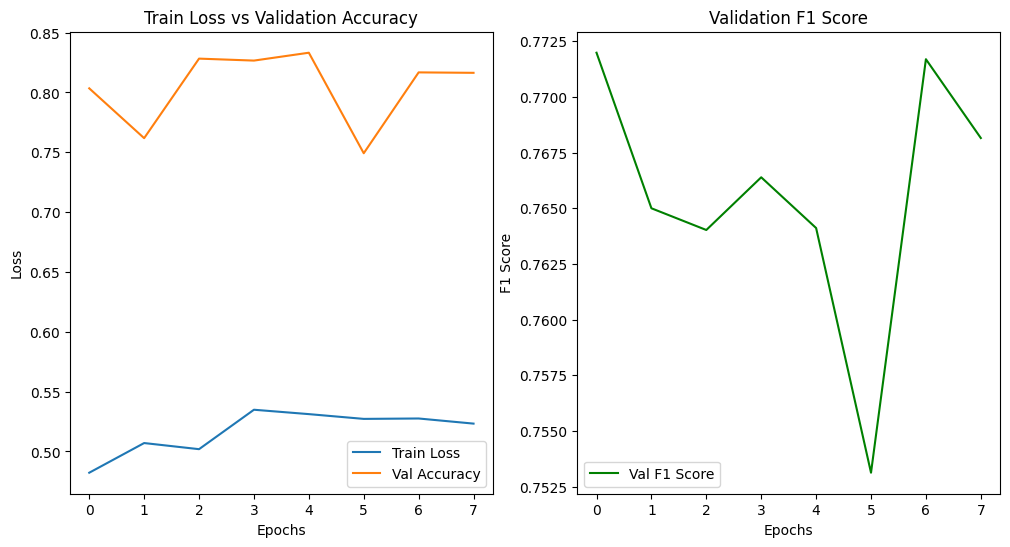

Validation Accuracy: 0.8164, F1: 0.7682, Recall: 0.8164
Training with hidden_dim=128, lr=0.01, batch_size=16
Epoch [1/10], Train Loss: 0.4009, Val Loss: 0.3898, Val Accuracy: 0.8535, Val F1: 0.8202, Val Recall: 0.8535
Epoch [2/10], Train Loss: 0.4189, Val Loss: 0.4234, Val Accuracy: 0.8363, Val F1: 0.7925, Val Recall: 0.8363
Epoch [3/10], Train Loss: 0.4615, Val Loss: 0.4819, Val Accuracy: 0.8075, Val F1: 0.7950, Val Recall: 0.8075
Epoch [4/10], Train Loss: 0.4634, Val Loss: 0.5368, Val Accuracy: 0.7507, Val F1: 0.7629, Val Recall: 0.7507
Training stopped due to patience limit.


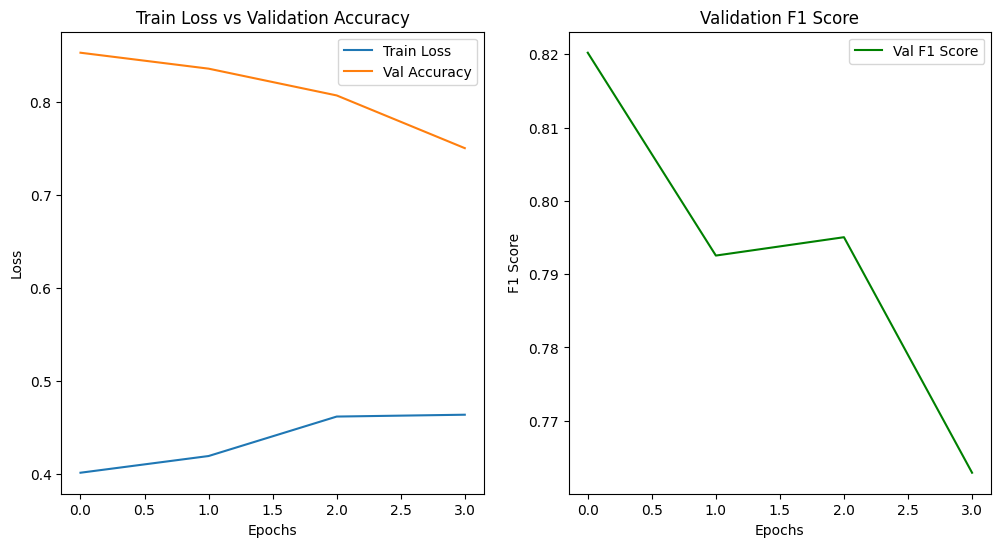

Validation Accuracy: 0.7507, F1: 0.7629, Recall: 0.7507
Training with hidden_dim=128, lr=0.01, batch_size=32
Epoch [1/10], Train Loss: 0.3710, Val Loss: 0.3491, Val Accuracy: 0.8672, Val F1: 0.8394, Val Recall: 0.8672
Epoch [2/10], Train Loss: 0.3690, Val Loss: 0.3828, Val Accuracy: 0.8566, Val F1: 0.8287, Val Recall: 0.8566
Epoch [3/10], Train Loss: 0.3971, Val Loss: 0.3937, Val Accuracy: 0.8471, Val F1: 0.8137, Val Recall: 0.8471
Epoch [4/10], Train Loss: 0.3922, Val Loss: 0.3797, Val Accuracy: 0.8530, Val F1: 0.8246, Val Recall: 0.8530
Training stopped due to patience limit.


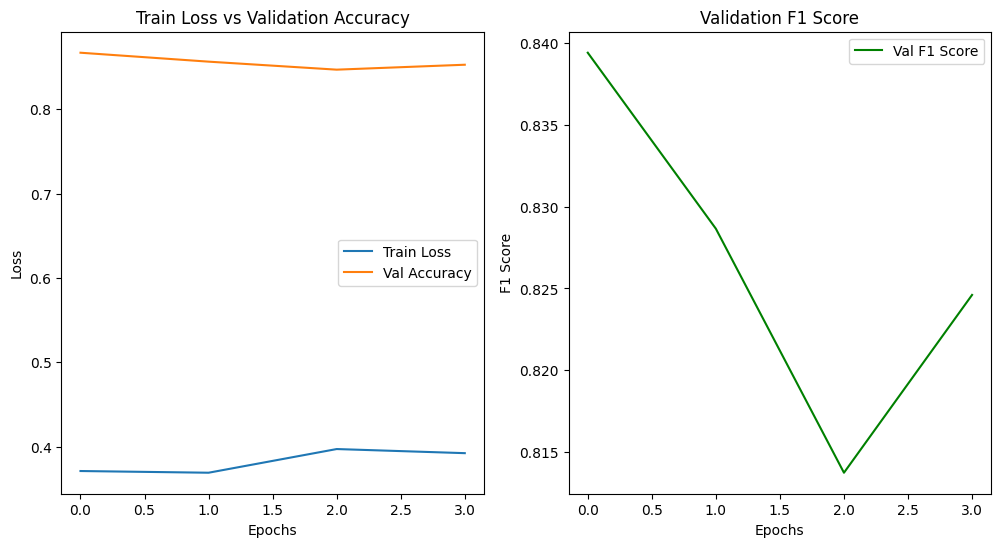

Validation Accuracy: 0.8530, F1: 0.8246, Recall: 0.8530
Training with hidden_dim=256, lr=0.0001, batch_size=8
Epoch [1/10], Train Loss: 0.3857, Val Loss: 0.3781, Val Accuracy: 0.8546, Val F1: 0.8360, Val Recall: 0.8546
Epoch [2/10], Train Loss: 0.3376, Val Loss: 0.3362, Val Accuracy: 0.8687, Val F1: 0.8460, Val Recall: 0.8687
Epoch [3/10], Train Loss: 0.3187, Val Loss: 0.3357, Val Accuracy: 0.8742, Val F1: 0.8527, Val Recall: 0.8742
Epoch [4/10], Train Loss: 0.3052, Val Loss: 0.3188, Val Accuracy: 0.8692, Val F1: 0.8413, Val Recall: 0.8692
Epoch [5/10], Train Loss: 0.2924, Val Loss: 0.3191, Val Accuracy: 0.8769, Val F1: 0.8649, Val Recall: 0.8769
Epoch [6/10], Train Loss: 0.2803, Val Loss: 0.3327, Val Accuracy: 0.8780, Val F1: 0.8590, Val Recall: 0.8780
Epoch [7/10], Train Loss: 0.2678, Val Loss: 0.3215, Val Accuracy: 0.8762, Val F1: 0.8617, Val Recall: 0.8762
Epoch [8/10], Train Loss: 0.2555, Val Loss: 0.3119, Val Accuracy: 0.8796, Val F1: 0.8726, Val Recall: 0.8796
Epoch [9/10], Trai

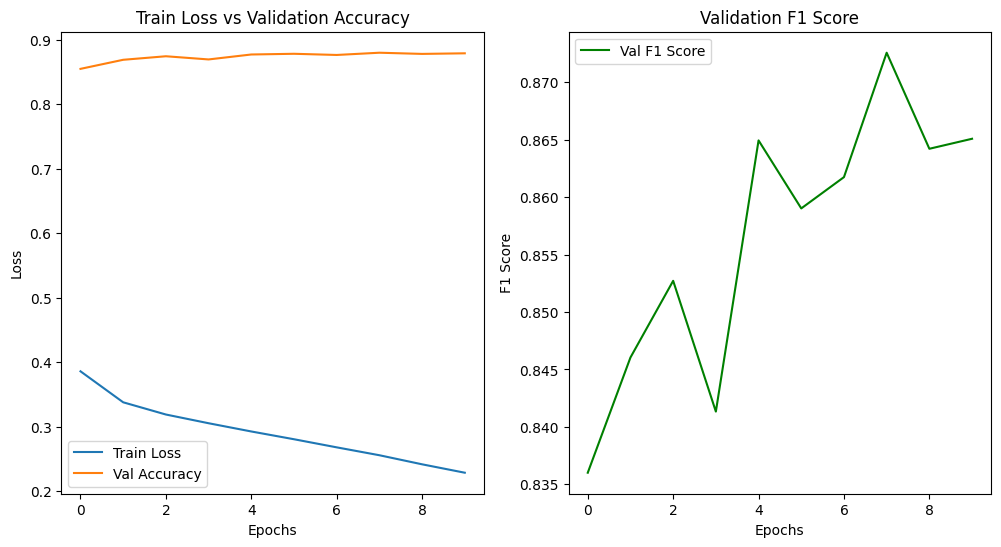

Validation Accuracy: 0.8787, F1: 0.8651, Recall: 0.8787
Training with hidden_dim=256, lr=0.0001, batch_size=16
Epoch [1/10], Train Loss: 0.3882, Val Loss: 0.3493, Val Accuracy: 0.8572, Val F1: 0.8457, Val Recall: 0.8572
Epoch [2/10], Train Loss: 0.3382, Val Loss: 0.3368, Val Accuracy: 0.8647, Val F1: 0.8360, Val Recall: 0.8647
Epoch [3/10], Train Loss: 0.3232, Val Loss: 0.3263, Val Accuracy: 0.8661, Val F1: 0.8557, Val Recall: 0.8661
Epoch [4/10], Train Loss: 0.3127, Val Loss: 0.3260, Val Accuracy: 0.8703, Val F1: 0.8545, Val Recall: 0.8703
Epoch [5/10], Train Loss: 0.3033, Val Loss: 0.3136, Val Accuracy: 0.8736, Val F1: 0.8614, Val Recall: 0.8736
Epoch [6/10], Train Loss: 0.2954, Val Loss: 0.3076, Val Accuracy: 0.8791, Val F1: 0.8648, Val Recall: 0.8791
Epoch [7/10], Train Loss: 0.2845, Val Loss: 0.3140, Val Accuracy: 0.8745, Val F1: 0.8507, Val Recall: 0.8745
Epoch [8/10], Train Loss: 0.2766, Val Loss: 0.3104, Val Accuracy: 0.8753, Val F1: 0.8655, Val Recall: 0.8753
Epoch [9/10], Tra

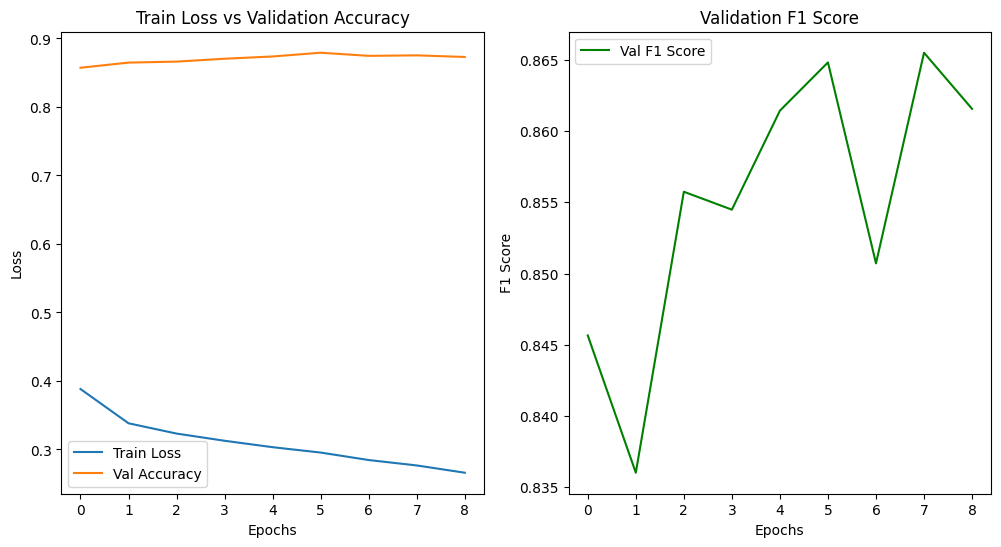

Validation Accuracy: 0.8729, F1: 0.8616, Recall: 0.8729
Training with hidden_dim=256, lr=0.0001, batch_size=32
Epoch [1/10], Train Loss: 0.4005, Val Loss: 0.3518, Val Accuracy: 0.8555, Val F1: 0.8322, Val Recall: 0.8555
Epoch [2/10], Train Loss: 0.3445, Val Loss: 0.3362, Val Accuracy: 0.8632, Val F1: 0.8485, Val Recall: 0.8632
Epoch [3/10], Train Loss: 0.3296, Val Loss: 0.3261, Val Accuracy: 0.8670, Val F1: 0.8547, Val Recall: 0.8670
Epoch [4/10], Train Loss: 0.3185, Val Loss: 0.3208, Val Accuracy: 0.8712, Val F1: 0.8530, Val Recall: 0.8712
Epoch [5/10], Train Loss: 0.3097, Val Loss: 0.3369, Val Accuracy: 0.8743, Val F1: 0.8513, Val Recall: 0.8743
Epoch [6/10], Train Loss: 0.3021, Val Loss: 0.3208, Val Accuracy: 0.8734, Val F1: 0.8521, Val Recall: 0.8734
Epoch [7/10], Train Loss: 0.2949, Val Loss: 0.3357, Val Accuracy: 0.8745, Val F1: 0.8534, Val Recall: 0.8745
Epoch [8/10], Train Loss: 0.2890, Val Loss: 0.3291, Val Accuracy: 0.8740, Val F1: 0.8501, Val Recall: 0.8740
Epoch [9/10], Tra

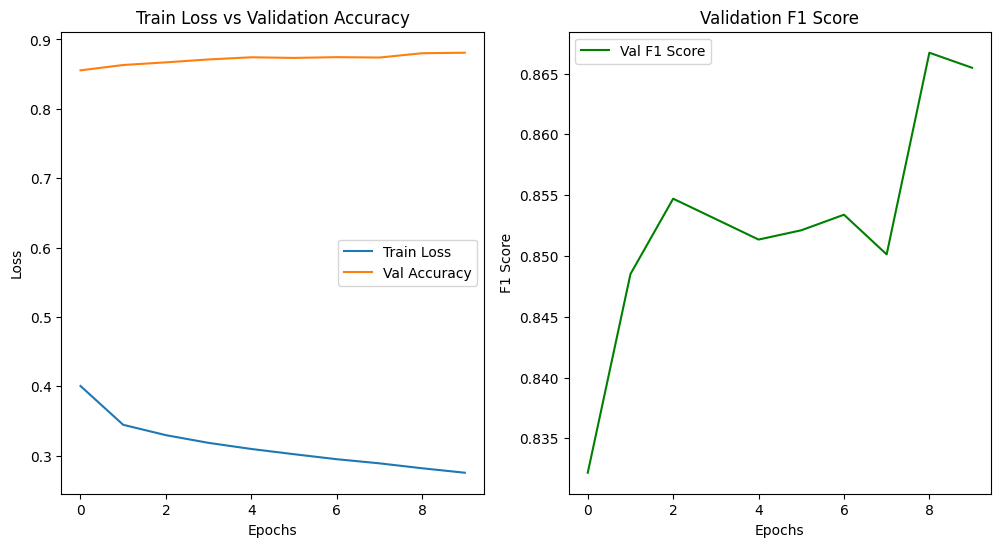

Validation Accuracy: 0.8809, F1: 0.8655, Recall: 0.8809
Training with hidden_dim=256, lr=0.001, batch_size=8
Epoch [1/10], Train Loss: 0.3569, Val Loss: 0.3264, Val Accuracy: 0.8725, Val F1: 0.8660, Val Recall: 0.8725
Epoch [2/10], Train Loss: 0.2906, Val Loss: 0.3091, Val Accuracy: 0.8815, Val F1: 0.8660, Val Recall: 0.8815
Epoch [3/10], Train Loss: 0.2539, Val Loss: 0.2965, Val Accuracy: 0.8807, Val F1: 0.8724, Val Recall: 0.8807
Epoch [4/10], Train Loss: 0.2064, Val Loss: 0.3150, Val Accuracy: 0.8851, Val F1: 0.8721, Val Recall: 0.8851
Epoch [5/10], Train Loss: 0.1571, Val Loss: 0.3546, Val Accuracy: 0.8831, Val F1: 0.8744, Val Recall: 0.8831
Epoch [6/10], Train Loss: 0.1199, Val Loss: 0.3987, Val Accuracy: 0.8647, Val F1: 0.8620, Val Recall: 0.8647
Epoch [7/10], Train Loss: 0.0964, Val Loss: 0.4534, Val Accuracy: 0.8762, Val F1: 0.8711, Val Recall: 0.8762
Training stopped due to patience limit.


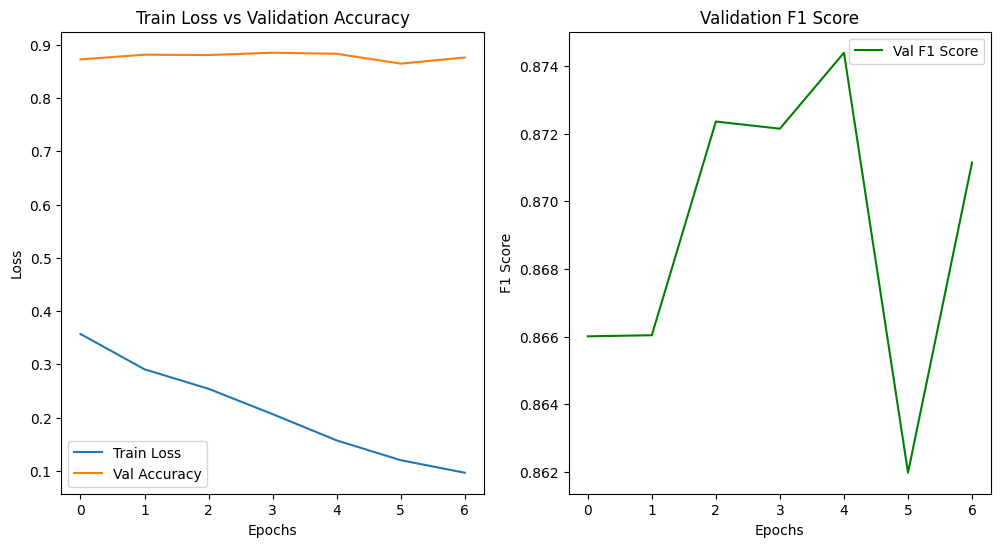

Validation Accuracy: 0.8762, F1: 0.8711, Recall: 0.8762
Training with hidden_dim=256, lr=0.001, batch_size=16
Epoch [1/10], Train Loss: 0.3605, Val Loss: 0.3186, Val Accuracy: 0.8778, Val F1: 0.8607, Val Recall: 0.8778
Epoch [2/10], Train Loss: 0.2962, Val Loss: 0.3124, Val Accuracy: 0.8780, Val F1: 0.8545, Val Recall: 0.8780
Epoch [3/10], Train Loss: 0.2598, Val Loss: 0.3088, Val Accuracy: 0.8793, Val F1: 0.8691, Val Recall: 0.8793
Epoch [4/10], Train Loss: 0.2123, Val Loss: 0.3208, Val Accuracy: 0.8816, Val F1: 0.8681, Val Recall: 0.8816
Epoch [5/10], Train Loss: 0.1546, Val Loss: 0.3719, Val Accuracy: 0.8778, Val F1: 0.8721, Val Recall: 0.8778
Epoch [6/10], Train Loss: 0.1050, Val Loss: 0.4397, Val Accuracy: 0.8789, Val F1: 0.8707, Val Recall: 0.8789
Epoch [7/10], Train Loss: 0.0799, Val Loss: 0.4829, Val Accuracy: 0.8681, Val F1: 0.8649, Val Recall: 0.8681
Training stopped due to patience limit.


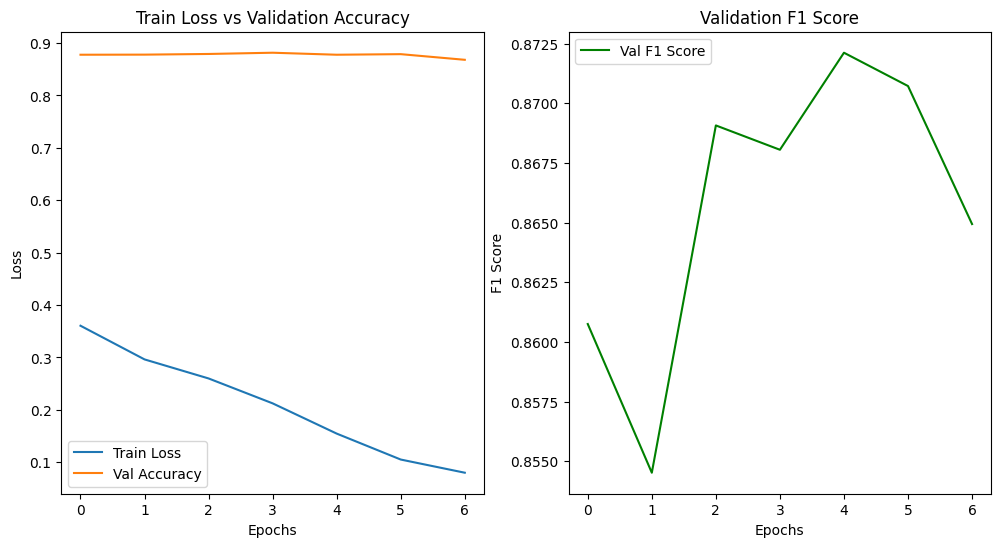

Validation Accuracy: 0.8681, F1: 0.8649, Recall: 0.8681
Training with hidden_dim=256, lr=0.001, batch_size=32
Epoch [1/10], Train Loss: 0.3734, Val Loss: 0.3199, Val Accuracy: 0.8712, Val F1: 0.8599, Val Recall: 0.8712
Epoch [2/10], Train Loss: 0.3046, Val Loss: 0.2990, Val Accuracy: 0.8824, Val F1: 0.8677, Val Recall: 0.8824
Epoch [3/10], Train Loss: 0.2721, Val Loss: 0.2957, Val Accuracy: 0.8816, Val F1: 0.8672, Val Recall: 0.8816
Epoch [4/10], Train Loss: 0.2313, Val Loss: 0.2982, Val Accuracy: 0.8829, Val F1: 0.8714, Val Recall: 0.8829
Epoch [5/10], Train Loss: 0.1776, Val Loss: 0.3206, Val Accuracy: 0.8829, Val F1: 0.8745, Val Recall: 0.8829
Epoch [6/10], Train Loss: 0.1206, Val Loss: 0.4076, Val Accuracy: 0.8793, Val F1: 0.8667, Val Recall: 0.8793
Epoch [7/10], Train Loss: 0.0821, Val Loss: 0.4685, Val Accuracy: 0.8668, Val F1: 0.8630, Val Recall: 0.8668
Training stopped due to patience limit.


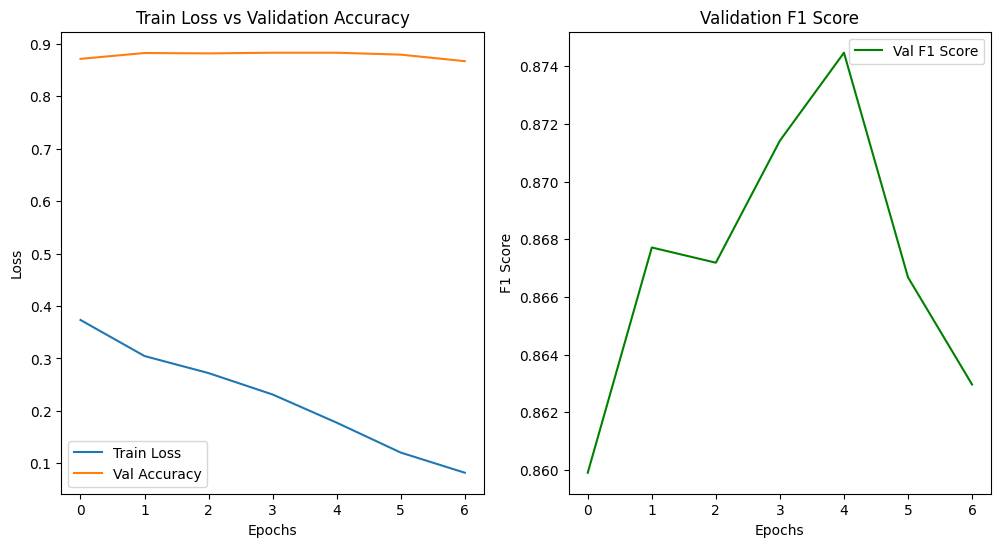

Validation Accuracy: 0.8668, F1: 0.8630, Recall: 0.8668
Training with hidden_dim=256, lr=0.01, batch_size=8
Epoch [1/10], Train Loss: 0.4722, Val Loss: 0.4310, Val Accuracy: 0.8407, Val F1: 0.8101, Val Recall: 0.8407
Epoch [2/10], Train Loss: 0.5348, Val Loss: 0.4885, Val Accuracy: 0.7918, Val F1: 0.7881, Val Recall: 0.7918
Epoch [3/10], Train Loss: 0.5440, Val Loss: 1.0983, Val Accuracy: 0.4444, Val F1: 0.4975, Val Recall: 0.4444
Epoch [4/10], Train Loss: 0.5843, Val Loss: 0.5800, Val Accuracy: 0.7209, Val F1: 0.7389, Val Recall: 0.7209
Training stopped due to patience limit.


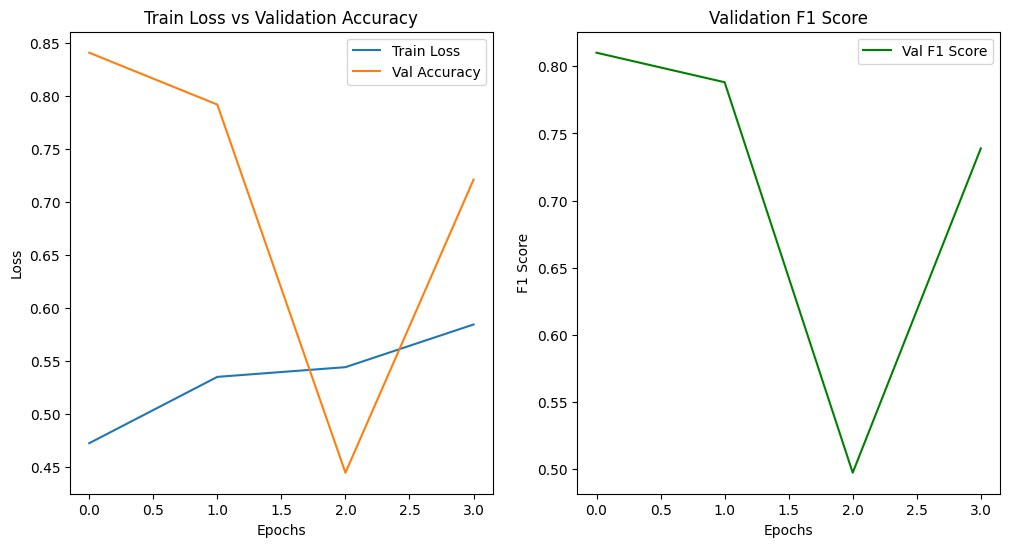

Validation Accuracy: 0.7209, F1: 0.7389, Recall: 0.7209
Training with hidden_dim=256, lr=0.01, batch_size=16
Epoch [1/10], Train Loss: 0.4431, Val Loss: 0.4166, Val Accuracy: 0.8216, Val F1: 0.8219, Val Recall: 0.8216
Epoch [2/10], Train Loss: 0.4623, Val Loss: 0.6856, Val Accuracy: 0.6634, Val F1: 0.7043, Val Recall: 0.6634
Epoch [3/10], Train Loss: 0.4963, Val Loss: 0.4545, Val Accuracy: 0.8287, Val F1: 0.8002, Val Recall: 0.8287
Epoch [4/10], Train Loss: 0.4983, Val Loss: 0.4530, Val Accuracy: 0.8418, Val F1: 0.7922, Val Recall: 0.8418
Epoch [5/10], Train Loss: 0.4974, Val Loss: 0.4512, Val Accuracy: 0.8290, Val F1: 0.7949, Val Recall: 0.8290
Epoch [6/10], Train Loss: 0.5008, Val Loss: 0.4970, Val Accuracy: 0.8360, Val F1: 0.7865, Val Recall: 0.8360
Epoch [7/10], Train Loss: 0.5123, Val Loss: 0.4438, Val Accuracy: 0.8278, Val F1: 0.8007, Val Recall: 0.8278
Training stopped due to patience limit.


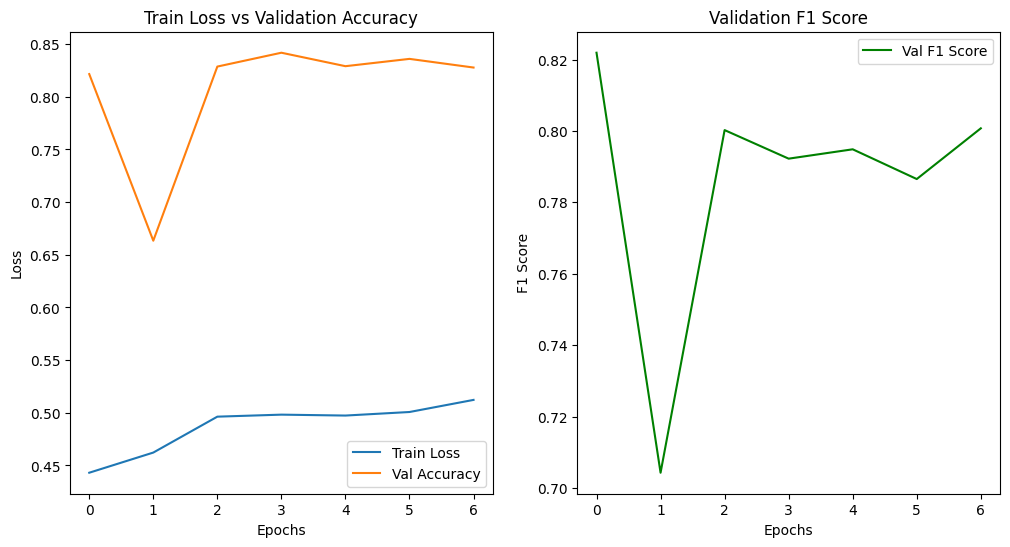

Validation Accuracy: 0.8278, F1: 0.8007, Recall: 0.8278
Training with hidden_dim=256, lr=0.01, batch_size=32
Epoch [1/10], Train Loss: 0.4001, Val Loss: 0.3670, Val Accuracy: 0.8539, Val F1: 0.8293, Val Recall: 0.8539
Epoch [2/10], Train Loss: 0.3860, Val Loss: 0.3784, Val Accuracy: 0.8570, Val F1: 0.8234, Val Recall: 0.8570
Epoch [3/10], Train Loss: 0.3696, Val Loss: 0.3648, Val Accuracy: 0.8564, Val F1: 0.8509, Val Recall: 0.8564
Epoch [4/10], Train Loss: 0.3905, Val Loss: 0.4459, Val Accuracy: 0.8471, Val F1: 0.8034, Val Recall: 0.8471
Epoch [5/10], Train Loss: 0.4004, Val Loss: 0.4114, Val Accuracy: 0.8570, Val F1: 0.8282, Val Recall: 0.8570
Training stopped due to patience limit.


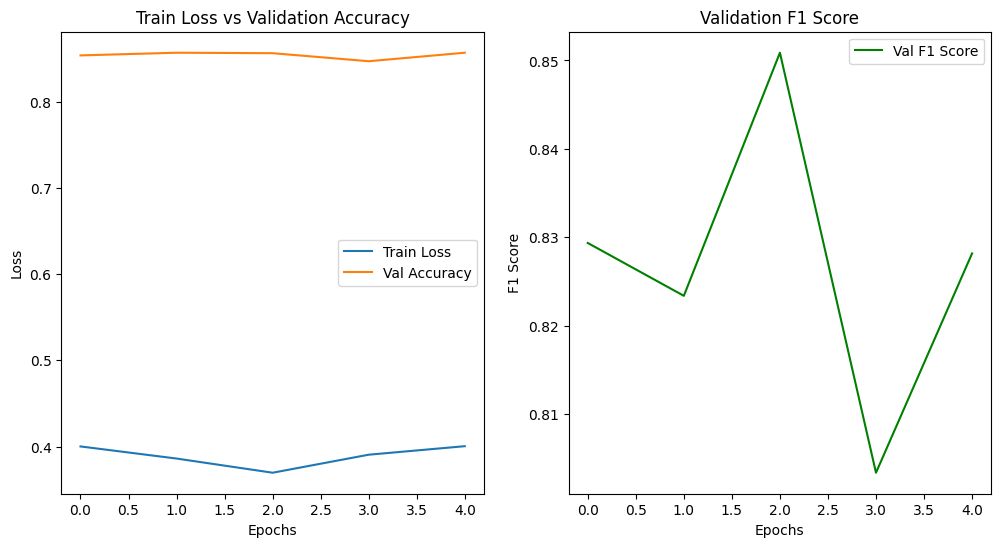

Validation Accuracy: 0.8570, F1: 0.8282, Recall: 0.8570

Best Hyperparameters: Hidden Dim: 128, LR: 0.001, Batch Size: 32
Best Validation Accuracy: 0.8816, F1: 0.8708, Recall: 0.8816


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model, best_params = random_search(train_loader, val_loader, device, epochs=10)

In [11]:
test_accuracy, test_f1, test_recall = test(best_model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.4f}, Test F1: {test_f1:.4f}, Test Recall: {test_recall:.4f}')

Test Accuracy: 0.9153, Test F1: 0.9104, Test Recall: 0.9153


In [14]:
def save_best_model_and_params(model, best_params, model_filename='best_model.pth', params_filename='best_params.json'):
    # Lưu mô hình vào tệp
    torch.save(model.state_dict(), model_filename)
    print(f"Model saved to {model_filename}")
    
    # Lưu các siêu tham số vào tệp JSON
    with open(params_filename, 'w') as f:
        json.dump(best_params, f, indent=4)
    print(f"Best parameters saved to {params_filename}")

# Lưu mô hình tốt nhất và siêu tham số
save_best_model_and_params(best_model, best_params)

Model saved to best_model.pth
Best parameters saved to best_params.json
